# Teleportation Protocol
In this document, we shall describe the quantum teleportation protocol. The teleportation protocol is essentially a method of transferring a quantum state from a transmitter (Alice) to a receiver (Bob) through the use of entangled pairs in the abscence of a regular quantum channel. We begin by importing the necessary components of qiskit.

In [1]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, execute
from qiskit.circuit import Gate
from qiskit.visualization import plot_bloch_multivector
from math import pi

## Objective
Alice has a qubit in a general quantum state given by

$$|\psi\rangle = \alpha|0\rangle + \beta|1\rangle$$

Alice and Bob share a bell state

$$|\phi\rangle = \frac{|00\rangle + |11\rangle}{\sqrt{2}}$$

with the first qubit owned by Alice and the second qubit by Bob. Alice needs to transfer the state $|\psi\rangle$ to Bob.

## Circuit Description & Analysis

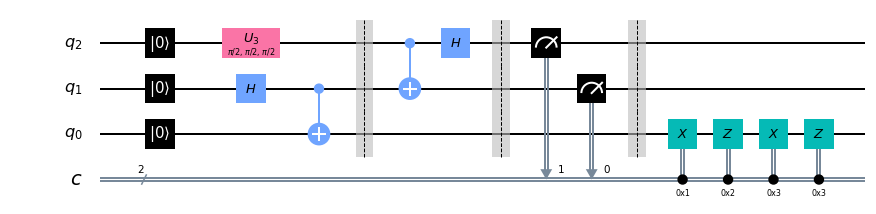

In [2]:
q = QuantumRegister(3, name='q')
c = ClassicalRegister(2, name='c')
circ = QuantumCircuit(q, c)
circ.reset(q)
circ.u3(pi/2,pi/2,pi/2,q[2])
circ.h(q[1])
circ.cx(q[1],q[0])
circ.barrier()
circ.cx(q[2],q[1])
circ.h(q[2])
circ.barrier()
circ.measure([q[2],q[1]],[c[1],c[0]])
circ.barrier()
circ.x(0).c_if(c,1)
circ.z(0).c_if(c,2)
circ.x(0).c_if(c,3)
circ.z(0).c_if(c,3)
circ.draw('mpl', reverse_bits=True)

### Barrier 1
The qubits $q_2$ and $q_1$ are owned by Alice and $q_0$ is owned by Bob. The first phase is the preparation phase where Alice prepares her state $|\psi\rangle$ via a general single qubit unitary transform $U_3$. We also assume that Alice and Bob each have one part of an entangled pair ($q_1$ and $q_0$). We model this in the circuit by an $H$ transform on $q_1$ followed by a CNOT gate to entangle the two qubits. The full state at this point is

$$|\Psi_1\rangle = |\psi\rangle \otimes \left(\frac{|00\rangle + |11\rangle}{\sqrt{2}}\right)
= \left(\alpha|0\rangle + \beta|1\rangle\right) \otimes \left(\frac{|00\rangle + |11\rangle}{\sqrt{2}}\right)$$

### Barrier 2
We next apply a CNOT gate with control qubit $q_2$ and target $q_1$ (on Alice's end). Resulting state is

$$\alpha|0\rangle \otimes \left(\frac{|00\rangle + |11\rangle}{\sqrt{2}}\right)
+ \beta|1\rangle \otimes \left(\frac{|10\rangle + |01\rangle}{\sqrt{2}}\right)$$

And then we apply an $H$ transform on $q_2$ (also on Alice's end). We get

$$\begin{align}
|\Psi_2\rangle 
&= \alpha\left(\frac{|0\rangle + |1\rangle}{\sqrt{2}}\right) \otimes \left(\frac{|00\rangle + |11\rangle}{\sqrt{2}}\right) + \beta\left(\frac{|0\rangle - |1\rangle}{\sqrt{2}}\right) \otimes \left(\frac{|10\rangle + |01\rangle}{\sqrt{2}}\right) \\
&= \left(\frac{|00\rangle}{2} \otimes \left(\alpha|0\rangle + \beta|1\rangle\right)
+ \frac{|01\rangle}{2} \otimes \left(\alpha|1\rangle + \beta|0\rangle\right)
+ \frac{|10\rangle}{2} \otimes \left(\alpha|0\rangle - \beta|1\rangle\right)
+ \frac{|11\rangle}{2} \otimes \left(\alpha|1\rangle - \beta|0\rangle\right)\right) \\
&= \left(\frac{|00\rangle \otimes |\psi\rangle + |01\rangle \otimes X|\psi\rangle
+ |10\rangle \otimes Z|\psi\rangle + |11\rangle \otimes XZ|\psi\rangle}{2}\right) \\
\end{align}$$


### Barrier 3
Qubits $q_2$ and $q_1$ are then measured by Alice. The state collapses to one of the following states

$$|\Psi_3\rangle = \begin{cases}
|\phi_1\rangle &= |00\rangle \otimes \left(\alpha|0\rangle + \beta|1\rangle\right) \\
|\phi_2\rangle &= |01\rangle \otimes \left(\alpha|1\rangle + \beta|0\rangle\right) \\
|\phi_3\rangle &= |10\rangle \otimes \left(\alpha|0\rangle - \beta|1\rangle\right) \\
|\phi_4\rangle &= |11\rangle \otimes \left(\alpha|1\rangle - \beta|0\rangle\right) \\
\end{cases}$$

Alice acquires the bit values of of $q_2$ and $q_1$, which she passes over to Bob over a classical channel.

### State Reconstruction
Depending on the bit values received from Alice, the following operations are applied by Bob on $q_0$

#### Case 1: 00
$|\psi\rangle_{Bob} = \left(\alpha|0\rangle + \beta|1\rangle\right) = |\psi\rangle$
#### Case 2: 01
$|\psi\rangle_{Bob} = X\left(\alpha|1\rangle + \beta|0\rangle\right) = |\psi\rangle$
#### Case 3: 10
$|\psi\rangle_{Bob} = Z\left(\alpha|0\rangle - \beta|1\rangle\right) = |\psi\rangle$
#### Case 4: 11
$|\psi\rangle_{Bob} = ZX\left(\alpha|1\rangle - \beta|0\rangle\right) = |\psi\rangle$

In any case, the state $|\psi\rangle$ is reconstructed by Bob. Teleportation is thus, achieved.

## Qiskit Implementation
We shall do a state vector simulation of the teleportation protocol. We shall start by defining the input state $|\psi\rangle$.
However, instead of defining $\alpha$ and $\beta$, we shall define the parameters $\theta$ and $\phi$ for ease of implementation

$$|\psi\rangle = \alpha|0\rangle + \beta|1\rangle = cos\left(\frac{\theta}{2}\right)|0\rangle + e^{i\phi}sin\left(\frac{\theta}{2}\right)|1\rangle$$

### Input Preparation

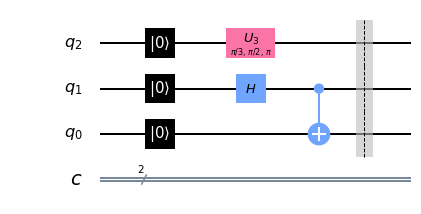

In [3]:
theta = pi/3
phi = pi/2
q = QuantumRegister(3, name='q')
c = ClassicalRegister(2, name='c')
circ = QuantumCircuit(q, c)
circ.reset(q)
circ.u3(theta,phi,pi,q[2])
circ.h(q[1])
circ.cx(q[1],q[0])
circ.barrier()
circ.draw('mpl', reverse_bits=True)

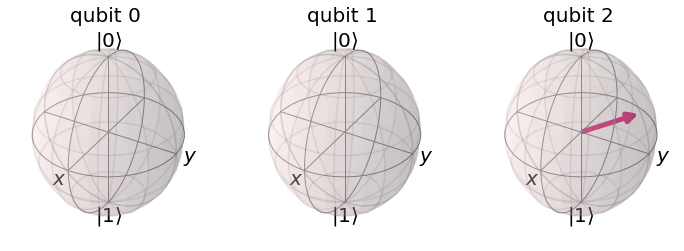

In [4]:
backend = Aer.get_backend('statevector_simulator')
job = execute(circ, backend)
state = job.result().get_statevector(circ)
plot_bloch_multivector(state)

Clearly, qubits $q_0$ and $q_1$ are in the maximally entangled state and qubit $q_2$ is our initial state. Next, we build the rest of the circuit and simulate teleportation.

### Teleportation

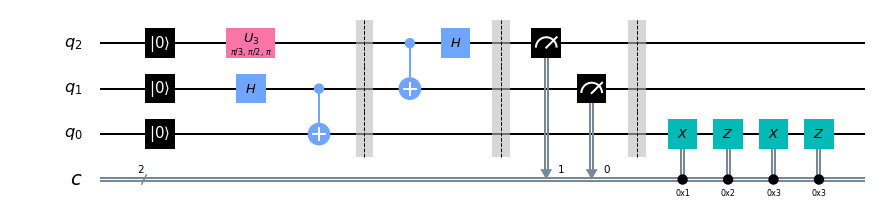

In [5]:
circ.cx(q[2],q[1])
circ.h(q[2])
circ.barrier()
circ.measure([q[2],q[1]],[c[1],c[0]])
circ.barrier()
circ.x(0).c_if(c,1)
circ.z(0).c_if(c,2)
circ.x(0).c_if(c,3)
circ.z(0).c_if(c,3)
circ.draw('mpl', reverse_bits=True)

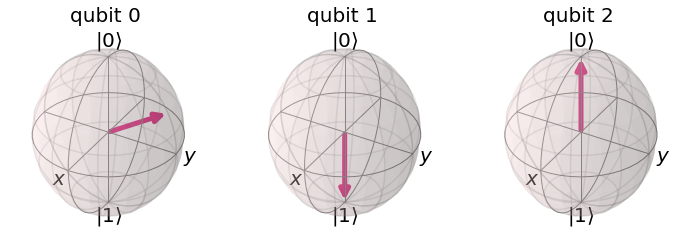

In [6]:
backend = Aer.get_backend('statevector_simulator')
job = execute(circ, backend)
state = job.result().get_statevector(circ)
plot_bloch_multivector(state)

Notice that the state $|\psi\rangle$, initially in $q_2$ (in Alice's possession) is now transferred to $q_0$ (in Bob's possession), while the other two qubits are randomly projected to one of the four computational basis states. Thus, teleportation is achieved.

## References
1. Mermin, N. D. (2007). Quantum computer science: An introduction. Cambridge University Press.
2. Nielsen, M. A., & Chuang, I. L. (2010). Quantum computation and quantum information: 10th anniversary edition. Cambridge University Press.
3. Qiskit documentation — Qiskit 0.19.3 documentation. (n.d.). Qiskit. https://qiskit.org/documentation/